In [1]:
# Parameters
seed = 42
rewards = [-100, -20, 0, 20, 140]
colors = ["red", "coral", "lightgrey", "lightgreen", "green"]
stage_colors=['paleturquoise','lightskyblue','royalblue','blue']
min_al = 3
from_to_str = {
    "(0,0)": [1, 2, 3],
    "(0,1)": [0],
    "(1,0)": [1, 2],
    "(1,1)": [2, 3],
    "(1,2)": [2, 3],
    "(2,0)": [1, 2],
    "(2,1)": [1, 2],
    "(2,2)": [2, 3],
    "(2,3)": [2, 3],
    "(3,0)": [3, 4],
    "(3,1)": [3, 4],
    "(3,2)": [3, 4],
    "(3,3)": [3, 4],
}
output_folder= '../../data/rawdata'
pydantic_folder= '../models'
n_train = 1000
n_test = 1
n_steps = 8
dataset_name = "dev"


In [2]:
%load_ext autoreload
%autoreload 2

import networkx as nx
import string
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
#from rn.utils.utils import save_json, make_dir
from utils import save_json, make_dir
import pydantic
import hashlib
import json
from collections import Counter

# yaml does not support objects with tuples as keys. This is a hacky workaround.
from_to = {(int(k[1]),int(k[3])):v for k,v in from_to_str.items()}

make_dir(output_folder)

test_file = os.path.join(output_folder, 'test_viz.json')
train_file = os.path.join(output_folder, 'train_viz.json')

random.seed(seed)
np.random.seed(seed)


In [3]:
def add_link(G, a, b):
    a_s = G.nodes[a]['stage']
    b_s = G.nodes[b]['stage']
    reward_idx = random.choice(from_to[(a_s,b_s)])
    G.add_edge(a, b, reward=rewards[reward_idx], reward_idx=reward_idx, color=colors[reward_idx])

def new_node(G, stage):
    idx = len(G)
    name = string.ascii_lowercase[idx%len(string.ascii_lowercase)]+string.ascii_lowercase[idx//len(string.ascii_lowercase)]
    G.add_node(idx, name=name, stage=stage)
    return idx

def filter_node(G, node, current_node):
    if node == current_node:
        return []
    if node in G[current_node]:
        return []
    a_s = G.nodes[current_node]['stage']
    b_s = G.nodes[node]['stage']
    return from_to.get((a_s, b_s), [])


def get_min_incoming(G, nodes):
    in_de = [G.in_degree(n) for n in nodes]
    min_in_de = min(in_de)
    return [n for n, ind in zip(nodes, in_de) if ind == min_in_de]

    
def find_nodes(G, current_node):
    return [
        n
        for n in G.nodes() 
        for _ in filter_node(G, n, current_node)
    ]


def sample_network():
    G = nx.DiGraph()

    node_stages = {
        0: 4,
        1: 1,
        2: 1,
        3: 1
    }

    for i in range(3):
        stage = random.randint(0,3)
        node_stages[stage] += 1

    for stage, n in node_stages.items():
        for i in range(n):
            new_node(G, stage)

    start_node = 0

    n_edges_per_node = 2

    for i in range(60):
        current_node = start_node
        for j in range(8):
            if len(G.out_edges(current_node)) < n_edges_per_node:
                potential_nodes = find_nodes(G, current_node)
                potential_nodes = get_min_incoming(G, potential_nodes)
                next_node = random.choice(potential_nodes)
                add_link(G, current_node, next_node)
                if len(G.edges) == (len(G.nodes) * n_edges_per_node):
                    break
            else:
                next_node = random.choice([e[1] for e in G.out_edges(current_node)])
            current_node = next_node
    return G

def plot_network(G):

    pos = nx.circular_layout(G)
    pos = list(pos.values())
    random.shuffle(pos)
    pos = {
        n: p for n, p in enumerate(pos)
    }

    edges = G.edges()
    edge_colors = [G[u][v]['color'] for u,v in edges]
    #labeldict={n: f"Node {n} / Level {d['stage']}" for n, d in G.nodes(data=True)}
    labeldict={n: f"{n}" for n, d in G.nodes(data=True)}


    f = plt.figure(1,figsize=(10,10))
    ax = f.add_subplot(1,1,1)
    # level legend
    leg1 = ax.legend([Line2D([0], [0], marker='o', color=stage_colors[l],markerfacecolor=stage_colors[l], markersize=15) for l in range(4)],
              [f'Level {l}' for l in range(4)],
              loc=1)
    # reward legend
    leg2 = ax.legend([Line2D([0], [0], color=colors[r], lw=3) for r in range(len(rewards))],
              [f'{rewards[r]}' for r in range(len(rewards))],
              loc=8,mode='expand',ncol=len(rewards))
    ax.add_artist(leg1)

    nx.draw(G, 
            pos, 
            node_color = [stage_colors[d['stage']] for n, d in G.nodes(data=True)],
            node_size=900,#[300*(d['stage']+1) for n, d in G.nodes(data=True)], 
            edge_color=edge_colors, 
            labels=labeldict, 
            font_size=16, 
            font_color="red",
            width=3,
            connectionstyle='arc3,rad=0.2')

### Display an example network

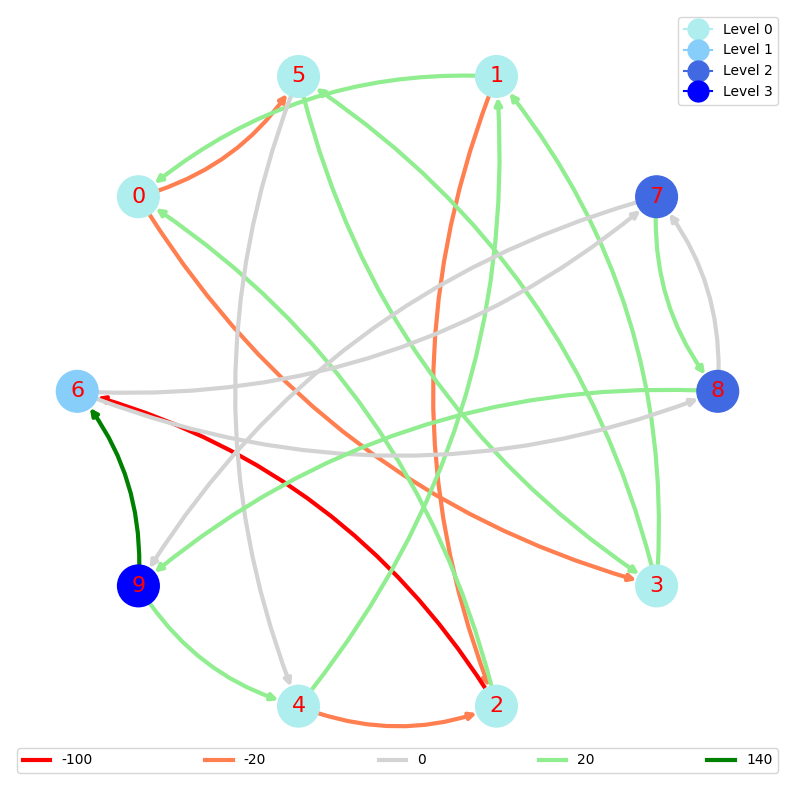

In [4]:
G = sample_network()
plot_network(G)

In [5]:
a = nx.json_graph.node_link_data(G)
a

{'directed': True,
 'multigraph': False,
 'graph': {},
 'nodes': [{'name': 'aa', 'stage': 0, 'id': 0},
  {'name': 'ba', 'stage': 0, 'id': 1},
  {'name': 'ca', 'stage': 0, 'id': 2},
  {'name': 'da', 'stage': 0, 'id': 3},
  {'name': 'ea', 'stage': 0, 'id': 4},
  {'name': 'fa', 'stage': 0, 'id': 5},
  {'name': 'ga', 'stage': 1, 'id': 6},
  {'name': 'ha', 'stage': 2, 'id': 7},
  {'name': 'ia', 'stage': 2, 'id': 8},
  {'name': 'ja', 'stage': 3, 'id': 9}],
 'links': [{'reward': -20,
   'reward_idx': 1,
   'color': 'coral',
   'source': 0,
   'target': 3},
  {'reward': -20, 'reward_idx': 1, 'color': 'coral', 'source': 0, 'target': 5},
  {'reward': 20,
   'reward_idx': 3,
   'color': 'lightgreen',
   'source': 1,
   'target': 0},
  {'reward': -20, 'reward_idx': 1, 'color': 'coral', 'source': 1, 'target': 2},
  {'reward': -100, 'reward_idx': 0, 'color': 'red', 'source': 2, 'target': 6},
  {'reward': 20,
   'reward_idx': 3,
   'color': 'lightgreen',
   'source': 2,
   'target': 0},
  {'reward': 

# Create Network Objects

In [6]:
from model import parse_network, calculate_q_value, calculate_trace
import torch as th
import torch_scatter

def parse_node(name, pos_map, id, **kwargs):
    return {
        'node_num': id,
        'display_name': name,
        'node_size': 3,
        'level':kwargs['stage'],
        **pos_map[id]
    }


def parse_link(source, target, reward, reward_idx,arc_type,source_x,source_y,arc_x,arc_y,target_x,target_y, **_):
    return {
        "source_num": source, # source_id before
        "target_num": target, # target_id before
        "reward": reward,
        "arc_type": arc_type,
        "source_x": source_x,
        "source_y": source_y,
        "arc_x": arc_x,
        "arc_y": arc_y,
        "target_x": target_x,
        "target_y": target_y

    }


def create_base_network_object(pos_map, starting_node=0, *, nodes, links, network_id, n_steps, **kwargs):
    return {
        'network_id': network_id,
        'nodes': [parse_node(pos_map=pos_map, **n) for n in nodes],
        'edges': [parse_link(**l) for l in links],
        'starting_node': starting_node}


def get_max_reward(network):
    edges, rewards = parse_network(network)
    # calculate q value for gamma = 0 (no pruning)
    Q = calculate_q_value(edges, rewards, n_steps=n_steps, n_nodes=len(network['nodes']), gamma=0)
    # get trace corresponding to q values
    edge_trace, node_trace = calculate_trace(Q, edges, starting_node=network['starting_node'])
    reward_trace = rewards[edge_trace]
    max_reward = reward_trace.sum()

    max_reward2 = th.where(network['starting_node'] == edges[:, 0], Q[0], th.tensor(-10000.)).max()

    if max_reward2 != max_reward:
        print('Rewards do not match')
        print(network['network_id'], max_reward2, max_reward)

    # TODO: check why this assertion is not always valid.
    # assert max_reward == max_reward2
    return max_reward2
    

def add_max_reward(network):
    return {
        **network,
        'max_reward': get_max_reward(network).item()
    }

def create_network_object(**kwargs):
    network = create_base_network_object(**kwargs)
    return add_max_reward(network)


## Store networks

counter Counter({0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 7: 2, 9: 2, 6: 1, 8: 1}), nodes are [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] (n=10)
counter Counter({0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 8: 2, 9: 2}), nodes are [0, 1, 2, 3, 4, 5, 6, 8, 9] (n=9)
counter Counter({0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 9: 2}), nodes are [0, 1, 2, 3, 4, 5, 6, 7, 9] (n=9)
counter Counter({0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 9: 2}), nodes are [0, 1, 2, 3, 4, 5, 6, 7, 9] (n=9)
counter Counter({0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 7: 2, 8: 2, 9: 2, 6: 1}), nodes are [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] (n=10)
counter Counter({0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 8: 2, 6: 1, 7: 1, 9: 1}), nodes are [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] (n=10)
counter Counter({0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 9: 2, 8: 1}), nodes are [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] (n=10)
counter Counter({0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 8: 2, 9: 2, 7: 1}), nodes are [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] (n=10)
counter Counte

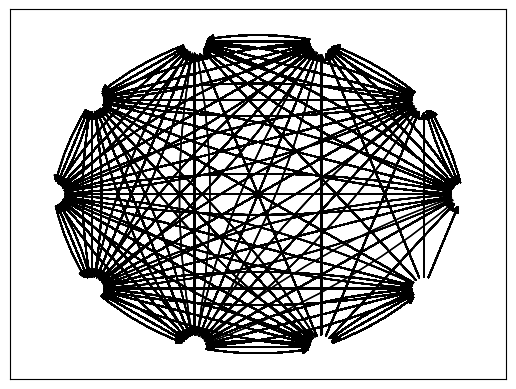

In [7]:
# parameters for visualization
node_size=300
arc_rad = 0.1

# create positions (x,y coordinates) for network nodes
G = sample_network()
network = nx.json_graph.node_link_data(G)
pos = nx.circular_layout(G)
#pos_map = {
#    k: {'x': v[0], 'y': v[0]}
#    for k, v in pos.items()
#}
pos_map = { k: {'x': v[0]*100, 'y': v[1]*100}
            for k, v in pos.items()
}

# sample and store training networks
networks = []
for i in range(n_train):
  
    G = sample_network()
    network = nx.json_graph.node_link_data(G)
    # NEW: add vertices for visualization purposes
    for ii, e in enumerate(G.edges()):
        if (reversed(e) in G.edges()):
            network['links'][ii]['arc_type'] = 'curved'
            arc = nx.draw_networkx_edges(
                G, pos, edgelist=[e], node_size=node_size,
                connectionstyle=f'arc3, rad = {arc_rad}')
        else:
            network['links'][ii]['arc_type'] = 'straight'
            arc = nx.draw_networkx_edges(
                G, pos, edgelist=[e], node_size=node_size)
        
        vert = arc[0].get_path().vertices.T[:, :3] * 100

        network['links'][ii]['source_x'] = vert[0, 0] 
        network['links'][ii]['source_y'] = vert[1, 0]
        network['links'][ii]['arc_x'] = vert[0, 1]
        network['links'][ii]['arc_y'] = vert[1, 1]
        network['links'][ii]['target_x'] = vert[0, 2]
        network['links'][ii]['target_y'] = vert[1, 2]

    network_id = hashlib.md5(json.dumps(network, sort_keys=True).encode('utf-8')).hexdigest()

    c = Counter([e['source'] for e in network['links']])
    #print('G network: ',all(value == 2 for value in c.values()))
    
    if all(value == 2 for value in c.values()) and len(list(c.keys()))==10:
        create_network = create_network_object(pos_map=pos_map, n_steps=n_steps, network_id=network_id, **network)
        networks.append(create_network)
    else:
        print(f'counter {c}, nodes are {list(c.keys())} (n={len(list(c.keys()))})')
        #c = Counter([e['source_id'] for e in create_network['edges']])
        #print('create netowrk object: ',all(value == 2 for value in c.values()))
        #networks.append(create_network_object(pos_map=pos_map, n_steps=n_steps, network_id=network_id, **network))
save_json(networks, train_file)


# sample and store test networks
networks = []
for i in range(n_test):
    #network_id = f'{dataset_name}_train_{i}'
    G = sample_network()
    network = nx.json_graph.node_link_data(G)
    # NEW: add vertices for visualization purposes
    for ii, e in enumerate(G.edges()):
        if (reversed(e) in G.edges()):
            network['links'][ii]['arc_type'] = 'curved'
            arc = nx.draw_networkx_edges(
                G, pos, edgelist=[e], node_size=node_size,
                connectionstyle=f'arc3, rad = {arc_rad}')
        else:
            network['links'][ii]['arc_type'] = 'straight'
            arc = nx.draw_networkx_edges(
                G, pos, edgelist=[e], node_size=node_size)
        
        vert = arc[0].get_path().vertices.T[:, :3] * 100

        network['links'][ii]['source_x'] = vert[0, 0] 
        network['links'][ii]['source_y'] = vert[1, 0]
        network['links'][ii]['arc_x'] = vert[0, 1]
        network['links'][ii]['arc_y'] = vert[1, 1]
        network['links'][ii]['target_x'] = vert[0, 2]
        network['links'][ii]['target_y'] = vert[1, 2]
        
    network_id = hashlib.md5(json.dumps(network, sort_keys=True).encode('utf-8')).hexdigest()
    networks.append(create_network_object(pos_map=pos_map, n_steps=n_steps, network_id=network_id, **network))
save_json(networks, test_file)   

## Use Pydantic to test whether JSON file respects Network schema

In [8]:
import json
from typing import Optional,List,Dict,Any
from pydantic import BaseModel,validator,parse_obj_as,ValidationError,root_validator
from collections import Counter

class node(BaseModel):
    
    node_num: int
    display_name: str
    node_size: int
    level: int
    x: float
    y: float

    @validator('node_num')
    def max_ten_nodes(cls, n):
        if n<0 or n>9:
            raise ValueError('node number must be a number between 0 and 9')
        return n
    @validator('level')
    def max_four_levels(cls, n):
        if n<0 or n>3:
            raise ValueError('level must be a number between 0 and 3')
        return n

    class Config:
        schema_extra = {
            "example": [
                {
                    'node_num':0,
                    'display_name': 'A',
                    'node_size':3,
                    'level':0,
                    'x':-10.394,
                    'y':3.2020
                }
            ]
        }

class edge(BaseModel):
    source_num: int
    target_num: int
    reward: int
    arc_type: str
    source_x: float
    source_y: float
    arc_x: float
    arc_y: float
    target_x: float
    target_y: float

    @validator('source_num')
    def check_source(cls, n):
        if n<0 or n>9:
            raise ValueError('source node number must be a number between 0 and 9')
        return n
    @validator('target_num')
    def check_target(cls, n):
        if n<0 or n>9:
            raise ValueError('target node number must be a number between 0 and 9')
        return n
    @validator('reward')
    def check_reward(cls, n):
        possible_rewards = [-100,-20,0,20,140]
        if n not in possible_rewards:
            raise ValueError(f'reward must be a value in {possible_rewards}')
        return n
    @validator('arc_type')
    def check_arc_type(cls, n):
        if n not in ['straight','curved']:
            raise ValueError('arc type must be chosen among possible options between straight or curved')
        return n
    @root_validator()
    def validate_no_self_connection(cls, values: Dict[str, Any]) -> Dict[str, Any]:
         if values.get("source_num") == values.get("target_num"):
              raise ValueError("source_num must be different from target_num")
         return values

    class Config:
        schema_extra = {
            "example": [
                {
                    'source_num': 0,
                    'target_num': 2,
                    'reward':20,
                    'arc_type': 'straight',
                    'source_x': 89.84720834968113,
                    'source_y': 7.376435889674515,
                    'arc_x': 34.54971253634034,
                    'arc_y': 47.55241560766308,
                    'target_x': -20.02973382010107,
                    'target_y': 87.20670189283723
                }
            ]
        }


class network(BaseModel):
    network_id: str
    nodes: List[node]
    edges: List[edge]
    starting_node: int
    max_reward: int



# Opening JSON file (train)
with open(train_file) as json_file:
    train = json.load(json_file)
try:
    network_list = [network(**n) for n in train]
except ValidationError as e:
    print(e)

# Opening JSON file (test)
with open(test_file) as json_file:
    test = json.load(json_file)
try:
    network_list = [network(**n) for n in test]
except ValidationError as e:
    print(e)


